In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pickle 
from ply import write_ply

from utilities import *
from VoxelGrid import *
import os

from PIL import ImageFont
from PIL import ImageDraw 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda' if torch.cuda.is_available() else 'cpu'




In [2]:
model="mic"
dataset= "../nerf_synthetic/" + model
focal, all_c2w, all_gt = get_data(dataset, "train")

LOAD DATA ../nerf_synthetic/mic/train


100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.77it/s]


In [3]:
back_focal, back_c2w, back_gt = get_data(dataset, "train", True)

LOAD DATA ../nerf_synthetic/mic/train


100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 94.40it/s]


In [4]:
red = 8
target_ims_carve, rays_carve = reduce_data(back_c2w, back_gt.squeeze(), back_focal, red)
print(red)
red = 8
target_ims, rays = reduce_data(all_c2w, all_gt, focal, red)
print(red)
red = 4
disp_ims, disp_rays = reduce_data(all_c2w, all_gt, focal, red)
print(red)

8
8
4


In [5]:
D_carve = RayDataset(target_ims_carve, rays_carve, device)
train_loader_carve = torch.utils.data.DataLoader(D_carve, batch_size=5000, shuffle=True)

100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.90it/s]


In [6]:
D = RayDataset(target_ims, rays, device)
train_loader = torch.utils.data.DataLoader(D, batch_size=5000, shuffle=True)

100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.82it/s]


In [7]:

class VoxelGridCarve(VoxelGrid):
    def __init__(self, size=128, bound_w=1, init_op=3):
        super().__init__(size, bound_w)
        self.colors_sum = torch.zeros_like(self.opacities)
        with torch.no_grad():
            self.opacities[:] = init_op
            self.colors[:] = 0
    def subdivide(self):
        super().subdivide()
        self.colors_sum = torch.zeros_like(self.opacities)
    def smooth_colors(self):
        with torch.no_grad():
            new_ar = 6*self.colors.clone()
            for disp1 in [1, self.size, self.size**2]:
                new_ar[:-disp1] +=self.colors[disp1:]
                new_ar[disp1:] += self.colors[:-disp1]
            self.colors[:] = new_ar/12
            
    def smooth_opacities(self):
        with torch.no_grad():
            new_ar = 6*self.opacities.clone()
            for disp1 in [1, self.size, self.size**2]:
                new_ar[:-disp1] +=self.opacities[disp1:]
                new_ar[disp1:] += self.opacities[:-disp1]
            self.opacities[:] = new_ar/12

    def carve(self, ordir_tuple, N_points, inv_depth=1.2):
        with torch.no_grad():
            ori = ordir_tuple[0][:, None,:]

            # WARNING: Assuming constant distance
            distances = 8/(N_points-1)
            scatter_points = torch.linspace(0,10, N_points, device=device)[None, :]/inv_depth
            p = ori + scatter_points[:,:,None]*(ordir_tuple[1][:, None, :])    

            # extract valid indices
            inds_3d = torch.floor(self.descartes_to_indices(p))
            in_bounds = self.in_bounds_indices(inds_3d)
            # meshgrid coordinates
            mesh_coords = self.flatten_3d_indices(inds_3d.long())
            mesh_coords[torch.logical_not(in_bounds)] = 0
            
            self.opacities[mesh_coords] = 0
            
    def color(self, ordir_tuple, pixels, N_points, inv_depth=1.2):
        with torch.no_grad():
            ori = ordir_tuple[0][:, None,:]

            # WARNING: Assuming constant distance
            distances = 8/(N_points-1)
            scatter_points = torch.linspace(0,10, N_points, device=device)[None, :]/inv_depth
            p = ori + scatter_points[:,:,None]*(ordir_tuple[1][:, None, :])    

            # extract valid indices
            inds_3d = torch.floor(self.descartes_to_indices(p))
            in_bounds = self.in_bounds_indices(inds_3d)
            # meshgrid coordinates
            mesh_coords = self.flatten_3d_indices(inds_3d.long()).long()
            mesh_coords[torch.logical_not(in_bounds)] = 0
            opacities = self.opacities[mesh_coords]*in_bounds.float() # not_in bounds: 0 opacity
            opacities = opacities*distances
            cumsum_opacities = torch.zeros_like(opacities, device=device)
            cumsum_opacities[:,1:] = torch.cumsum(opacities[:,:-1], 1)

            transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
            
            self.colors[mesh_coords,:] += transp_term[..., None]*pixels[:, None, :]
            self.colors_sum[mesh_coords] += transp_term
            
            #is_more_opaque = transp_term > self.colors_sum[mesh_coords]
            #r_pixels = pixels[:, None, :].repeat(1, mesh_coords.shape[1], 1)            
            #self.colors[mesh_coords[is_more_opaque],:] = r_pixels[is_more_opaque]
            #self.colors_sum[mesh_coords[is_more_opaque]] = transp_term[is_more_opaque]

In [8]:
VG = VoxelGridCarve(128, 1.4, 40)
N_points = 900

In [9]:
def carve(grid, loader, N_points):
    for batch_idx, (rays, pixels) in enumerate(tqdm(loader)):
        rays, pixels = (rays[0].to(device),rays[1].to(device)), pixels.to(device)
        mask = (pixels==1)
        grid.carve((rays[0][mask],rays[1][mask]) , N_points)

def color(grid, loader, N_points):
    for batch_idx, (rays, pixels) in enumerate(tqdm(loader)):
        rays, pixels = (rays[0].to(device),rays[1].to(device)), pixels.to(device)
        mask = (pixels==1).all(1)
        mask = torch.logical_not(mask)
        grid.color((rays[0][mask],rays[1][mask]), pixels[mask], N_points)
    with torch.no_grad():
        mask = VG.colors_sum>0
        VG.colors[mask] = VG.colors[mask]/(VG.colors_sum[mask, None])
 


100%|█████████████████████████████████████████| 800/800 [00:29<00:00, 27.29it/s]


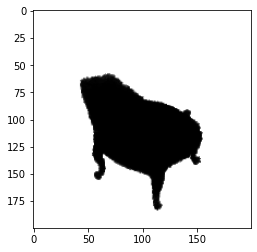

In [19]:
carve(VG, train_loader_carve, N_points)
plt.imshow(VG.render_large_image_from_rays(disp_rays[30],(N_points,1.2)))
plt.show()

100%|█████████████████████████████████████████| 800/800 [00:26<00:00, 30.65it/s]


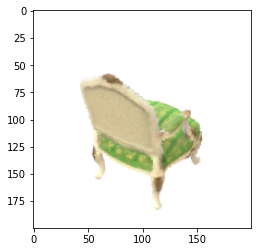

In [20]:
color(VG, train_loader, N_points)
plt.imshow(VG.render_large_image_from_rays(disp_rays[30],(N_points,1.2)))
plt.show()

In [118]:
VG2 = VoxelGridCarve(128, 1.4, 20)
with torch.no_grad():
    VG2.colors[:] = VG.colors.clone()
    VG2.opacities[:] = VG.opacities.clone()
    mask = VG.colors_sum>1
    VG2.colors[mask] = VG.colors[mask]/(VG.colors_sum[mask, None])
    VG2.clamp()
 

In [119]:
VG.clamp()

In [21]:
VG.save('chair_new.obj')

In [22]:
VG.save_pointcloud()

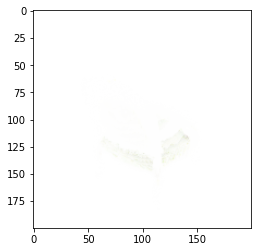

In [120]:
#VG.clamp()
plt.imshow(VG2.render_large_image_from_rays(disp_rays[30],(N_points,1.2)))
plt.show()

In [ ]:
VG.colors

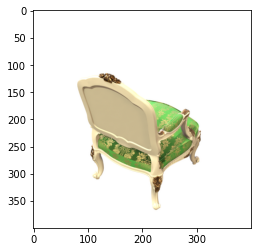

In [29]:
plt.imshow(disp_ims[30])
plt.show()

In [31]:
VG.save('chair_carve3.obj')

# Spherical

In [50]:
def color_sph(grid, loader, N_points):
    for batch_idx, (rays, pixels) in enumerate(tqdm(loader)):
        rays, pixels = (rays[0].to(device),rays[1].to(device)), pixels.to(device)
        mask = (pixels==1).all(1)
        mask = torch.logical_not(mask)
        grid.color((rays[0][mask],rays[1][mask]), pixels[mask], N_points) 
    with torch.no_grad():
        mask = VG.colors_sum>0
        for i in range(3):
            VG.colors[:,i,:][mask] = VG.colors[:,i,:][mask] /(VG.colors_sum[mask])
        

In [62]:
VG = VoxelGridSphericalCarve(128, 1.4, 40, 4)


In [63]:
carve(VG, train_loader_carve, 900)

100%|█████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 30.99it/s]


In [64]:
color_sph(VG, train_loader, 900)

100%|█████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 28.72it/s]


In [65]:
with torch.no_grad():
    VG.colors /= np.sqrt(2)

In [66]:
np.sqrt((im**2).sum(2)).flatten().shape

(10000,)

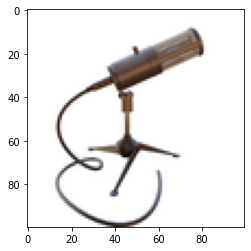

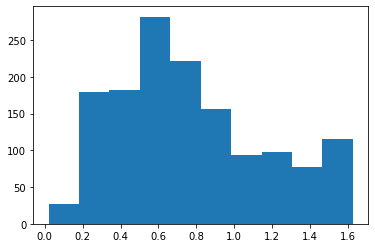

In [67]:
im = target_ims[1] 
plt.imshow(im)
plt.show()

h = np.sqrt((im**2).sum(2)).flatten()
h = h[h<np.sqrt(3)-0.1]       
        
        
plt.hist(h)
plt.show()

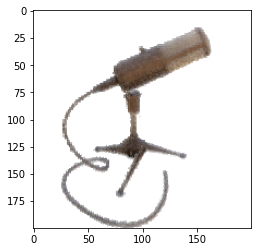

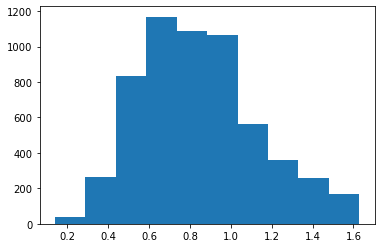

In [68]:
im2=VG.render_large_image_from_rays(disp_rays[1],(900,1.2))
plt.imshow(im2)
plt.show()

h = np.sqrt((im2**2).sum(2)).flatten()
h = h[h<np.sqrt(3)-0.1]       
        
        
plt.hist(h)
plt.show()

In [69]:
VG.save('mic_sph.obj')

In [40]:
m = torch.tensor([0.2821, 0.2742, 0.2972, 0.2742, 0.2433, 0.3730, 0.0347, 0.3730, 0.2433])

In [47]:
m =  torch.tensor([0.2821, 0.2519, 0.3344, 0.2519, 0.2053, 0.3855, 0.1279, 0.3855, 0.2053])

In [48]:
(m**2).sum()

tensor(0.7162)

In [14]:
cust_c2ws = create_rotation_matrices(3,-15, n=60)
red_fac=2
ordir_rays=[]
for c2w in cust_c2ws:
    ray_np = get_rays_np(800,800, focal, c2w)
    oris = ray_np[0][::red_fac,::red_fac]
    direct = ray_np[1][::red_fac,::red_fac] # direction. optimal fac:3
    ordir_rays.append((oris, direct))

In [16]:
m = torch.zeros((len(cust_c2ws),9))
for image_ind in range(len(cust_c2ws)):
    p = torch.tensor(ordir_rays[image_ind][0][0,0])
    m[image_ind,:] = VG.view_harmonics(p)
    

In [18]:
for i in range(5000):
    VG.view_harmonics(p)

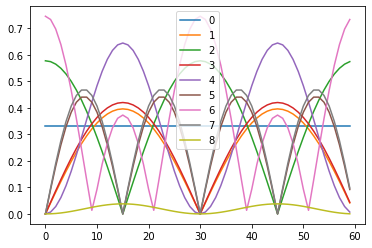

In [202]:
for i in range(0,9):
    plt.plot(m[:,i], label=str(i))
plt.legend()

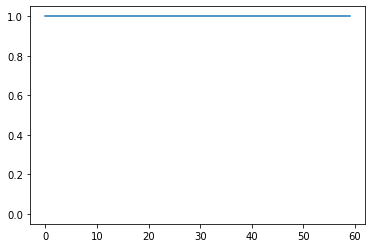

In [203]:
plt.plot(torch.sqrt((m**2).sum(1)))
plt.plot([0],[0])

In [141]:
sph_harm(2,2,0.5, 0.5)

(0.04797056732238562+0.07470973210396138j)